## map2loop: From Topology fom Local file or Loop WFS Server to outputs to 3D mdoelling program Hamersley

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into gempy to make a 3D model 

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
%matplotlib inline

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "../test_data3/m2l_config.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_base=-8200

#PATHS

test_data_path='../test_data3/'
geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
m2m_cpp_path='../m2m_cpp/'


#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#codes and labels these refer to specific fields (codes) in GIS layer or database that contain the info needed for these calcs and text substrings (labels) in the contents of these fields
c_l= {
#Ori

In [3]:





use_interpolations=True       #use interpolated dips/contacts as additional constraints

local_paths=False              #use local copies of data






## First we test to see if we have access to the online data we need


In [4]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
hawaii=m2l_utils.have_access("oos.soest.hawaii.edu")

if(not (loopwfs & hawaii)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: oos.soest.hawaii.edu


## Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

In [5]:
if((not local_paths) and net):
    structure_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    c_l= {
    #Orientations
      "d": "dip",                  #field that contains dip information
      "dd": "dip_dir",             #field that contains dip direction information
      "sf": 'feature',             #field that contains information on type of structure
      "bedding": 'Bed',            #text to search for in field defined by sfcode to show that this is a bedding measurement
    #Stratigraphy
      "g": 'group_',               #field that contains coarser stratigraphic coding
      "c": 'code',                 #field that contains finer stratigraphic coding
      "ds": 'descriptn',           #field that contains information about lithology
      "u": 'unitname',             #field that contains alternate stratigraphic coding (not used??)
      "r1": 'rocktype1',           #field that contains  extra lithology information
      "r2": 'rocktype2',           #field that contains even more lithology information
      "sill": 'sill',              #text to search for in field defined by dscode to show that this is a sill
      "intrusive": 'intrusive',    #text to search for in field defined by dscode to show that this is an intrusion
      "volcanic": 'volcanic',      #text to search for in field defined by dscode to show that this is an intrusion
    #Timing
      "min": 'min_age_ma',         #field that contains minimum age of unit defined by ccode
      "max": 'max_age_ma',         #field that contains maximum age of unit defined by ccode
    #faults and folds
      "f": 'feature',              #field that contains information on type of structure
      "fault": 'Fault',            #text to search for in field defined by fcode to show that this is a fault
      "fold": 'Fold axial trace',  #text to search for in field defined by fcode to show that this is a fold axial trace
      "n": 'name',                 #field that contains information on name of fault (not used??)
      "t": 'type',                 #field that contains information on type of fold
    #ids
      "o": 'objectid',             #field that contains unique id of geometry object
      "gi": 'geopnt_id'            #field that contains unique id of structure point
    }

## Plot geology polygons and bounding box

http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox=500057,7455348,603028,7567953&srs=EPSG:28350


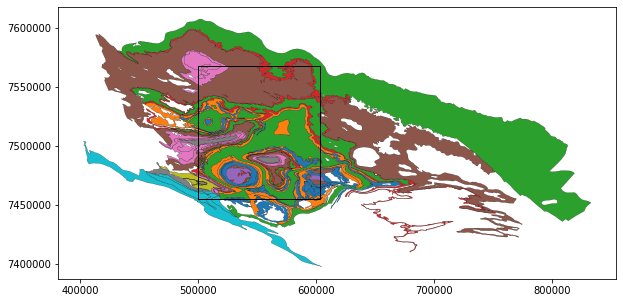

In [6]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save to file as WKT

In [7]:
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l)

186  polygons


## Read and save WAROX point data as WKT

297  points


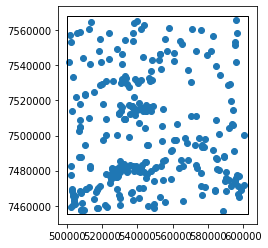

In [8]:
warox = gpd.read_file(structure_file,bbox=bbox)

sub_pts = warox[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

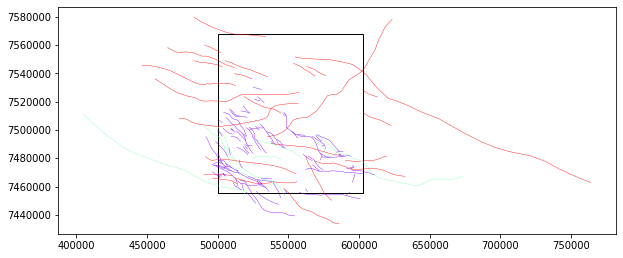

In [9]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [10]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

134  polylines


## Create map2model input file

In [11]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,minx,maxx,miny,maxy)


## Calculate topology

In [12]:
os.chdir(m2m_cpp_path)
print(os.getcwd())
%system map2model.exe Parfile

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


['Reading data from the file: Parfile',
 '--- COLUMN NAMES IN CSV DATA FILES: -------------------------------------------------------------',
 'OBJECT COORDINATES              =WKT',
 'FAULT: ID                       =objectid',
 'FAULT: FEATURE                  =feature',
 'POINT: ID                       =geopnt_id',
 'POINT: DIP                      =dip',
 'POINT: DIP DIR                  =dip_dir',
 'POLYGON: ID                     =objectid',
 'POLYGON: LEVEL1 NAME            =unitname',
 'POLYGON: LEVEL2 NAME            =group_',
 'POLYGON: MIN AGE                =min_age_ma',
 'POLYGON: MAX AGE                =max_age_ma',
 'POLYGON: CODE                   =code',
 'POLYGON: DESCRIPTION            =descriptn',
 'POLYGON: ROCKTYPE1              =rocktype1',
 'POLYGON: ROCKTYPE2              =rocktype2',
 '--- SOME CONSTANTS: ----------------------------------------------------------------------------',
 'FAULT AXIAL FEATURE NAME        =Fold axial trace',
 'SILL UNIT DESCRIPTION

## Simple network graph of the geology with legend

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


0    'A-HAm-cib'
1    'A-FO-od'
2    'A-HAu-xsl-ci'
3    'P_-HAw-fr'
4    'A-FOj-xs-b'
5    'P_-SKq-stq'
6    'A-b-PRK'
7    'A-HAd-kd'
8    'A-FOo-bbo'
9    'A-s-PMI'
10    'A-FO-xo-a'
11    'A-FOh-xs-f'
12    'A-FOp-bs'
13    'P_-WYm-sp'
14    'A-FOu-bbo'
15    'P_-HAb-cib'
16    'P_-TK-s'
17    'P_-HAj-xci-od'
18    'P_-TKk-sf'
19    'P_-TKa-xs-k'
20    'P_-SKb-bb'
21    'P_-WYa-s'
22    'A-s-PRK'
23    'A-FOr-b'
24    'P_-HAo-ci'
25    'P_-WYd-kd'
26    'A-mgn-PMI'
27    'P_-TKo-stq'
28    'A-mgn-PRK'


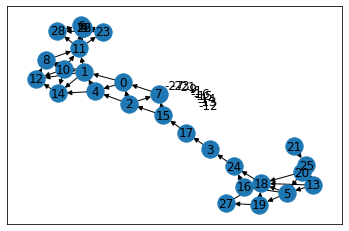

In [13]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Topology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/2.%20map2loop_after_topology.ipynb

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [14]:
os.chdir('../map2loop')

print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [15]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


#print(os.getcwd())
#os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Next we define an area of interest and some other basic stuff

In [16]:
print(os.getcwd())
#test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


contact_decimate=5

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

In [17]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if((not local_paths) and net):     
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)



116.9555521867685 118.0503484485386 -23.055227990891293 -21.94491765252865
dtm geotif saved as ../test_data3/dtm/dtm.tif
reprojected dtm geotif saved as ../test_data3/dtm/dtm_rp.tif


## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.


-12 A_b_PRK ----------------------
choices: 1
6 A_b_PRK

-13 A_mgn_PMI ----------------------
choices: 1
26 A_mgn_PMI

-14 A_mgn_PRK ----------------------
choices: 1
28 A_mgn_PRK

-15 A_s_PMI ----------------------
choices: 1
9 A_s_PMI

-16 A_s_PRK ----------------------
choices: 1
22 A_s_PRK

-1 Fortescue_Group ----------------------
choices: 2
4 A_FOj_xs_b
10 A_FO_xo_a
1 A_FO_od
14 A_FOu_bbo
12 A_FOp_bs
8 A_FOo_bbo
11 A_FOh_xs_f
23 A_FOr_b
....
10 A_FO_xo_a
4 A_FOj_xs_b
1 A_FO_od
14 A_FOu_bbo
12 A_FOp_bs
8 A_FOo_bbo
11 A_FOh_xs_f
23 A_FOr_b

-9 Hamersley_Group ----------------------
choices: 1
24 P__HAo_ci
3 P__HAw_fr
17 P__HAj_xci_od
15 P__HAb_cib
2 A_HAu_xsl_ci
7 A_HAd_kd
0 A_HAm_cib

-21 Shingle_Creek_Group ----------------------
choices: 1
20 P__SKb_bb
5 P__SKq_stq

-23 Turee_Creek_Group ----------------------
choices: 4
19 P__TKa_xs_k
27 P__TKo_stq
18 P__TKk_sf
16 P__TK_s
....
19 P__TKa_xs_k
27 P__TKo_stq
16 P__TK_s
18 P__TKk_sf
....
19 P__TKa_xs_k
16 P__TK_s
27 P__TKo_stq
18 

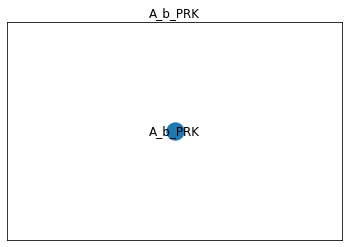

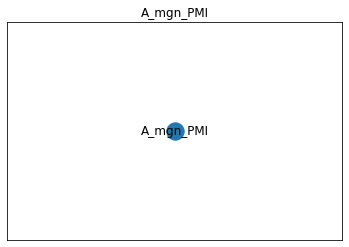

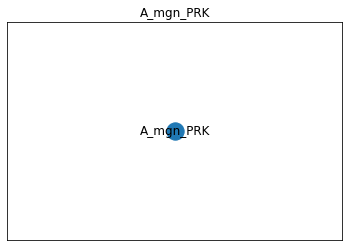

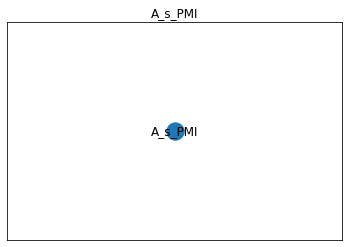

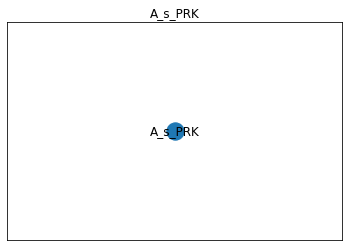

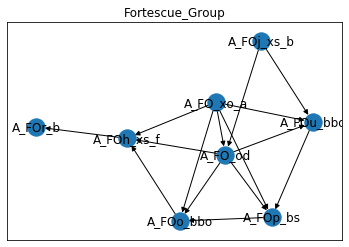

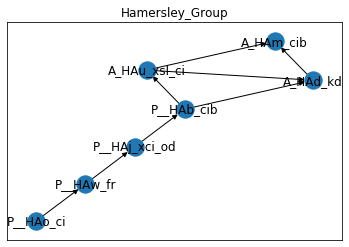

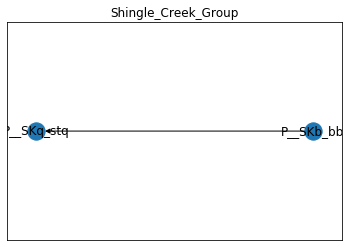

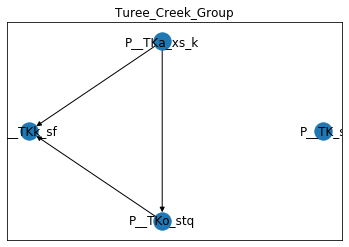

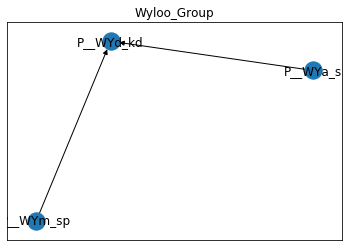

In [18]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox=500057,7455348,603028,7567953&srs=EPSG:28350


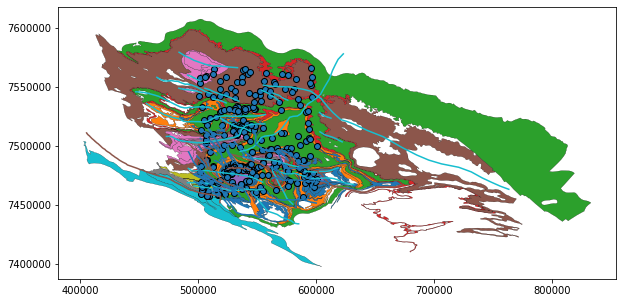

In [19]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs
#display(faults)
sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

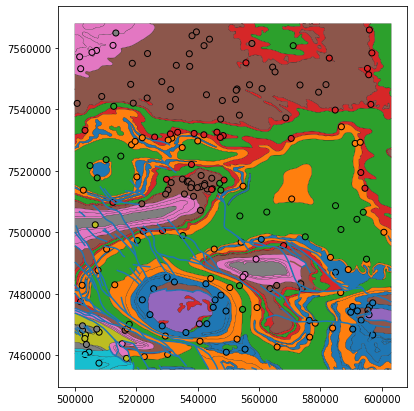

In [20]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]
#display(sfcode)

all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]



#display(structure_code)
geol_clip=m2l_utils.clip_shp(geology, polygo)
faults_clip=m2l_utils.clip_shp(all_faults,polygo)
#display(faults_clip)
structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['t'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')

geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,group_,min,max,ave
0,0,Wyloo_Group,1796.0,2008.0,1902.0
1,1,Shingle_Creek_Group,2031.0,2208.0,2119.5
2,2,Turee_Creek_Group,2208.0,2445.0,2326.5
3,3,Hamersley_Group,2445.0,2629.0,2537.0
4,4,Fortescue_Group,2629.0,2775.0,2702.0
5,5,A_mgn_PMI,2890.0,3225.0,3057.5
6,6,A_mgn_PRK,3221.0,3225.0,3223.0
7,7,A_s_PMI,3225.0,3530.0,3377.5
8,8,A_b_PRK,3225.0,3530.0,3377.5
9,9,A_s_PRK,3225.0,3530.0,3377.5


,index,min,max,ave
group_,,,,
Wyloo_Group,0,1796.0,2008.0,1902.0
Shingle_Creek_Group,1,2031.0,2208.0,2119.5
Turee_Creek_Group,2,2208.0,2445.0,2326.5
Hamersley_Group,3,2445.0,2629.0,2537.0
Fortescue_Group,4,2629.0,2775.0,2702.0
A_mgn_PMI,5,2890.0,3225.0,3057.5
A_mgn_PRK,6,3221.0,3225.0,3223.0
A_s_PMI,7,3225.0,3530.0,3377.5
A_b_PRK,8,3225.0,3530.0,3377.5


[]

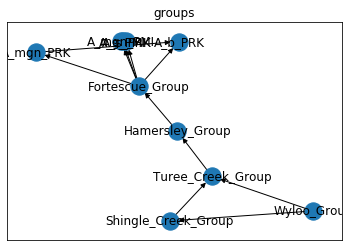

P__WYm_sp
P__WYa_s
P__WYd_kd
P__SKb_bb
P__SKq_stq
P__TKa_xs_k
P__TKo_stq
P__TKk_sf
P__TK_s
P__HAo_ci
P__HAw_fr
P__HAj_xci_od
P__HAb_cib
A_HAu_xsl_ci
A_HAd_kd
A_HAm_cib
A_FOj_xs_b
A_FO_xo_a
A_FO_od
A_FOu_bbo
A_FOp_bs
A_FOo_bbo
A_FOh_xs_f
A_FOr_b
A_s_PMI
A_mgn_PRK
A_b_PRK
A_s_PRK
A_mgn_PMI


In [21]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up :

<img src='../graphics/polarity.png'>

Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

In [22]:
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.save_orientations(structure_code,output_path,c_l,orientation_decimate,dtm)


169 orientations saved to ../test_data3/output//orientations.csv


## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

Orientations----------
 10 [('Wyloo_Group', 1), ('Shingle_Creek_Group', 1), ('Turee_Creek_Group', 1), ('Hamersley_Group', 1), ('Fortescue_Group', 1), ('A_s_PMI', 1), ('A_mgn_PRK', 0), ('A_b_PRK', 1), ('A_s_PRK', 0), ('A_mgn_PMI', 1)]
Contacts----------
 29 {'P_-WYa-s', 'A-HAm-cib', 'P_-TK-s', 'P_-TKk-sf', 'A-FOp-bs', 'A-FOo-bbo', 'P_-TKa-xs-k', 'A-FOr-b', 'A-HAu-xsl-ci', 'P_-WYm-sp', 'P_-SKb-bb', 'P_-HAo-ci', 'P_-WYd-kd', 'P_-HAb-cib', 'A-FO-od', 'A-FO-xo-a', 'P_-HAj-xci-od', 'A-s-PMI', 'A-mgn-PRK', 'A-mgn-PMI', 'A-b-PRK', 'A-s-PRK', 'A-FOj-xs-b', 'A-FOu-bbo', 'P_-SKq-stq', 'A-FOh-xs-f', 'A-HAd-kd', 'P_-TKo-stq', 'P_-HAw-fr'}


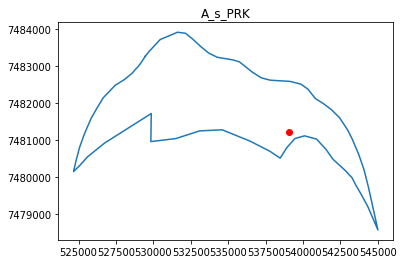

extra orientations saved as ../test_data3/output//empty_series_orientations.csv


In [23]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,geol_clip,structure_clip,c_l)

## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.

<font color='red'>Needs also to account for case when missing surface in stratigraphy means that locally basal polyline can ALSO be anothe rthan youngest surface.</font>
<img src='../graphics/base.png'>

In [24]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,geol_clip,contact_decimate,c_l,intrusion_mode)

decimation: 1 / 5
surfaces: 30
polygons: 206
[[1, 'P__WYm_sp'], [2, 'P__WYa_s'], [3, 'P__WYd_kd'], [4, 'P__SKb_bb'], [5, 'P__SKq_stq'], [6, 'P__TKa_xs_k'], [7, 'P__TKo_stq'], [8, 'P__TKk_sf'], [9, 'P__TK_s'], [10, 'P__HAo_ci'], [11, 'P__HAw_fr'], [12, 'P__HAj_xci_od'], [13, 'P__HAb_cib'], [14, 'A_HAu_xsl_ci'], [15, 'A_HAd_kd'], [16, 'A_HAm_cib'], [17, 'A_FOj_xs_b'], [18, 'A_FO_xo_a'], [19, 'A_FO_od'], [20, 'A_FOu_bbo'], [21, 'A_FOp_bs'], [22, 'A_FOo_bbo'], [23, 'A_FOh_xs_f'], [24, 'A_FOr_b'], [25, 'A_s_PMI'], [26, 'A_mgn_PRK'], [27, 'A_b_PRK'], [28, 'A_s_PRK'], [29, 'A_mgn_PMI']]
BoundingBox(left=495410.28918764635, bottom=7450094.777709385, right=608566.3181052292, top=7573269.830020713)
basal contacts saved allpts= 9423 deci_pts= 2307
saved as ../test_data3/tmp/all_contacts.csv and ../test_data3/tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [25]:
display(ls_dict)

{0: {'id': 0,
  'code': 'A_FOp_bs',
  'group_': 'Fortescue_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x271bd149e80>},
 1: {'id': 1,
  'code': 'A_FOo_bbo',
  'group_': 'Fortescue_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x271bd149c50>},
 2: {'id': 2,
  'code': 'A_FOh_xs_f',
  'group_': 'Fortescue_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x271baea9940>},
 3: {'id': 3,
  'code': 'A_FOh_xs_f',
  'group_': 'Fortescue_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x271beaa80b8>},
 4: {'id': 4,
  'code': 'A_FOh_xs_f',
  'group_': 'Fortescue_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x271beb23e80>},
 5: {'id': 5,
  'code': 'A_s_PMI',
  'group_': 'A_s_PMI',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x271bd2dbba8>},
 6: {'id': 6,
  'code': 'A_HAu_xsl_ci',
  'group_': 'Hamersley_Group',
  'geometry': <shapely.ge

In [26]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

(207,)
basal contacts without faults saved as ../test_data3/tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

In [27]:
m2l_geometry.save_contacts_with_faults_removed(tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,c_l,dst_crs,dtm)

undecimated points: 2307
2004 decimated contact points saved as ../test_data3/output//contacts4.csv


## Save fault as contact info and and orientation info make vertical (for the moment)

In [28]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,c_l,fault_decimate)
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

fault orientations saved as ../test_data3/output/fault_orientations.csv
fault positions saved as ../test_data3/output/faults.csv
fault dimensions saved as ../test_data3/output/fault_dimensions.csv
fault-fault, fault-group and fault-unit relationship tables saved as:
../test_data3/output/fault-fault-relationships.csv
../test_data3/output/group-fault-relationships.csv
../test_data3/output/unit-fault-relationships.csv


## Create basal contact points with orientation from orientations and basal points

contacts = gpd.read_file(tmp_path+'basal_contacts2.shp') #load orientation data as geopandas dataframe 
structures = gpd.read_file(tmp_path+'structure_clip.shp') #load orientation data as geopandas dataframe 

m2l_geometry.create_basal_contact_orientations(contacts,structures,output_path,dtm,2500,ccode,gcode,dcode,ddcode)


## Creates fold axial trace points

In [29]:
m2l_geometry.save_fold_axial_traces(tmp_path+'faults_clip.shp',output_path,dtm,c_l,fold_decimate)

fold axial traces saved as ../test_data3/output/fold_axial_traces.csv


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with three possible sub-surface configurations:

<b>saucers: \\_____/ <br>
pancakes: /_____\\   
domes: /‾\\</b>

Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>
Doesn't account for faults yet...

In [30]:

print(os.getcwd())


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [31]:
#%run -i "../test_data3/m2l_config.py"
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10



In [32]:


dtm = rasterio.open(dtm_reproj_file)

In [33]:
m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,pluton_form,pluton_dip,contact_decimate,c_l)


0 Wyloo_Group
1 Shingle_Creek_Group
2 Turee_Creek_Group
3 Hamersley_Group
4 Fortescue_Group
5 A_s_PMI
6 A_mgn_PRK
7 A_b_PRK
8 A_s_PRK
9 A_mgn_PMI
False
../test_data3/output/ign_orientations_domes.csv
A-mgn-PMI_7366
A-mgn-PRK_16193
10 A_mgn_PMI_7366
11 A_mgn_PRK_16193
0 Wyloo_Group
1 Shingle_Creek_Group
2 Turee_Creek_Group
3 Hamersley_Group
4 Fortescue_Group
5 A_s_PMI
6 A_mgn_PRK
7 A_b_PRK
8 A_s_PRK
9 A_mgn_PMI
10 A_mgn_PMI_7366
11 A_mgn_PRK_16193
pluton contacts and orientations saved as:
../test_data3/output/ign_contacts.csv
../test_data3/output/ign_orientations_domes.csv


## Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of Notebooks 4,5,6 and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for poulating parts of maps where little structural data is available

In [34]:
use_gcode=('Hamersley Group','Fortescue Group','Wyloo Group','Shingle Creek Group','Turee Creek Group' ) ################# MOVE UP   #########################
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

In [35]:
print(c_l['g'])
print(use_gcode)

group_
('Hamersley Group', 'Fortescue Group', 'Wyloo Group', 'Shingle Creek Group', 'Turee Creek Group')


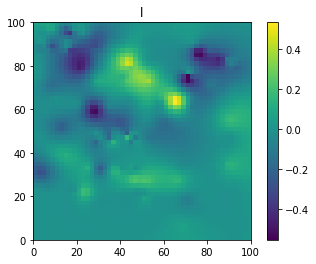

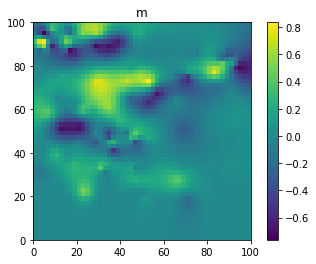

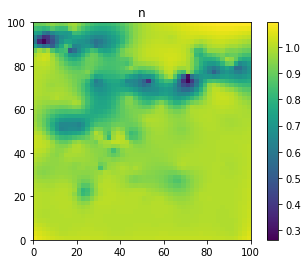

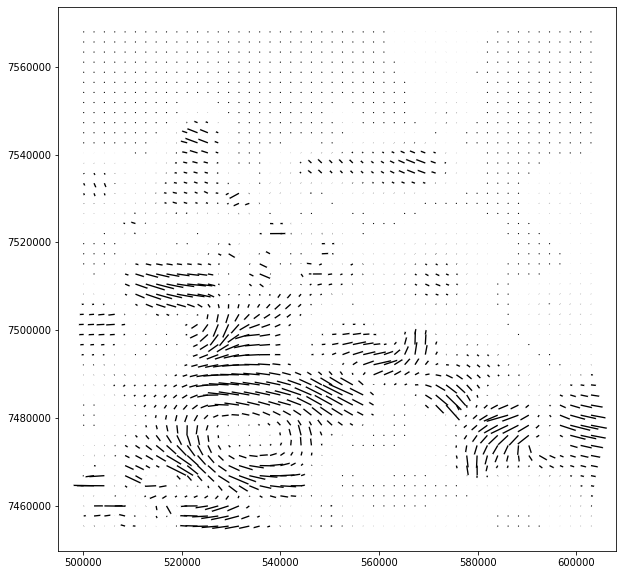

orientations interpolated as dip dip direction ../test_data3/tmp/interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data3/tmp/interpolation_l.csv etc.


In [36]:
m2l_interpolation.interpolate_orientations(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,gridx,gridy)

## Interpolates a regular grid from a shapefile of from contacts and saves out three csv files of l & m direction cosines and strike data

Can choose between various RBF and IDW options  

<font face color='red'>Best with basal contacts only, using Notebook #1 as this avoids intrusive  and fault contacts being considered</font>

In [37]:
geology_file=tmp_path+'basal_contacts.shp'

dtm = rasterio.open(dtm_reproj_file)
use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group' ) ################# MOVE UP   #########################


176
6807 1328.7966407308122 525.2523567890748
8695 682.2054117958178 500.3340552216396


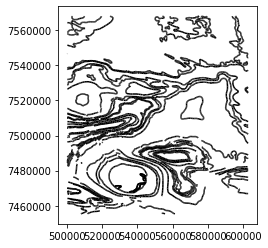

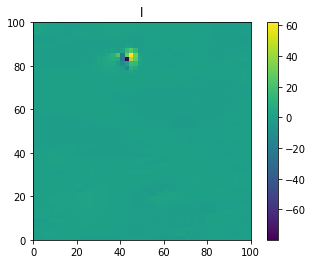

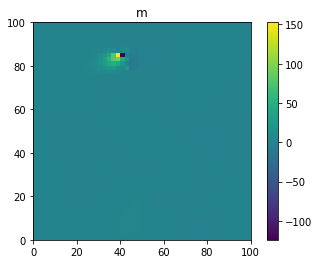

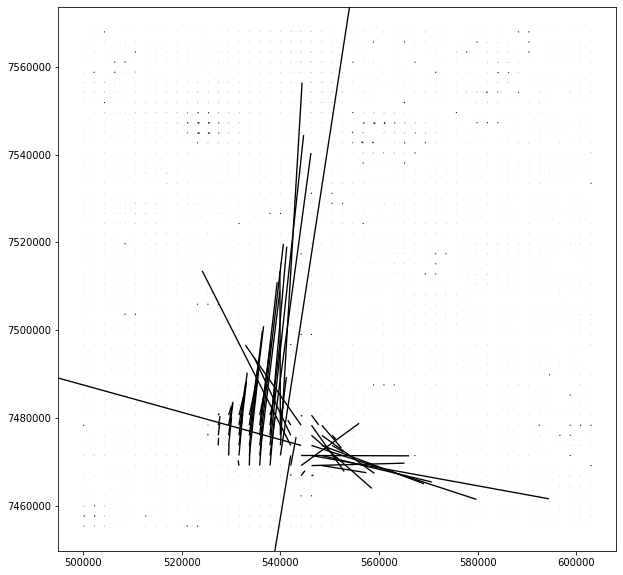

contacts interpolated as strike ../test_data3/tmp/interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../test_data3/tmp/interpolation_contacts_l.csv etc.


In [38]:
m2l_interpolation.interpolate_contacts(geology_file,tmp_path,dtm,bbox,c_l,use_gcode,scheme,gridx,gridy)


## Combines rbf of contact orientations with rbf of dip/dipdir measurements

Uses normalised direction cosines **(l,m,n)**:  
- **l,m** from RBF of basal contact orientations  
- **signs of l & m** from misorientation with RBF of orientation data and  
- **n** from RBF of orientation data  
  
May be useful for adding data where no orientations are available (e.g. in fault bounded domains) and for calculating true thickness of layers. Assumes a 2D plane of data, but if 3D RBF was calulated and projected contact info was used it should apply with topography too. 

In [39]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'combo.csv'

lc=np.loadtxt(tmp_path+'interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

In [40]:
m2l_interpolation.join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox)


{'init': 'EPSG:28350'} None


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


contacts and orientations interpolated as dip dip direction ../test_data3/tmp/combo_full.csv


# gempy test 


## Convert stratigraphy GML to time-sorted groups and units


Takes GML file produced by topology code, geology polygons, structure points and dtm to create 3D model.<br><br>
Limitations: no faults yet, no plutons yet, no dykes, no sills. Faults and plutons will come soon, sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty.

<font face color='red'>The way this loads data to gempy is not right, so all the units end up in one series... but it gives the basic idea </font>


## Preprocess data to ensure it meets gempy's requirements

In [41]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PRK_32',  'A_mgn_PMI_520' ) ################# MOVE UP   #########################
else:
    use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PMI_7366',  'A_mgn_PRK_16193' ) ################# MOVE UP   #########################


print('only processing',use_gcode)
m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,pluton_form)

only processing ('Hamersley_Group', 'Fortescue_Group', 'Wyloo_Group', 'Shingle_Creek_Group', 'Turee_Creek_Group', 'A_mgn_PMI_7366', 'A_mgn_PRK_16193')
no contacts for the group: A_s_PMI
no contacts for the group: A_mgn_PMI
no contacts for the group: A_mgn_PRK
no contacts for the group: A_s_PRK
no contacts for the group: A_b_PRK
no contacts for the group: A_s_PMI
no contacts for the group: A_mgn_PRK
no contacts for the group: A_b_PRK
no contacts for the group: A_s_PRK
no contacts for the group: A_mgn_PMI
no orientations for the group: A_s_PMI
no orientations for the group: A_mgn_PMI
no orientations for the group: A_mgn_PRK
no orientations for the group: A_s_PRK
no orientations for the group: A_b_PRK
['A_s_PMI', 'A_mgn_PRK', 'A_b_PRK', 'A_s_PRK', 'A_mgn_PMI', 'A_s_PMI', 'A_mgn_PMI', 'A_mgn_PRK', 'A_s_PRK', 'A_b_PRK']
dud orientation: P__WYd_kd
dud orientation: P__WYd_kd
dud orientation: A_s_PRK
dud orientation: A_s_PRK
dud orientation: A_s_PRK
dud orientation: A_s_PRK
dud orientation: A_

## Now we define the basic model and load the orientation and lithological information
mj: We inset the model dimensions as once reprojects the edge pixels of the topography are undefined. Probably doesn't need to be that extreme (unit is metres). Could use parameter <b>maxtopo</b> to 

In [42]:
import gempy as gp

geo_model = gp.create_model(test_data_name) 

gp.init_data(geo_model, extent=[minx, maxx, miny, maxy, model_base, model_top],
    resolution = (50,50,50), 
      #path_o = './test_data/output/hams2_orientations.txt',
      path_o = output_path+'orientations_clean.csv',
      path_i = output_path+'contacts_clean.csv', default_values=True); #%%      
      #path_o = './test_data3/output/ign_orientations_saucers.csv',
      #path_i = './test_data3/output/ign_contacts.csv', default_values=True); #%%

Active grids: ['regular']


## Show example lithological points

In [43]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,595340.779974,7.475217e+06,648.0,0.694578,0.338324,0.499787,A_mgn_PMI_7366,Default series,1,1,1.000000e-08
1,598761.529573,7.475077e+06,671.0,0.709767,0.337705,0.499889,A_mgn_PMI_7366,Default series,1,1,1.000000e-08
2,599690.780193,7.475238e+06,638.0,0.713893,0.338417,0.499743,A_mgn_PMI_7366,Default series,1,1,1.000000e-08
3,601532.969011,7.474814e+06,620.0,0.722073,0.336535,0.499663,A_mgn_PMI_7366,Default series,1,1,1.000000e-08
4,602892.489648,7.474514e+06,644.0,0.728109,0.335203,0.499769,A_mgn_PMI_7366,Default series,1,1,1.000000e-08


## Show example orientations

In [44]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
156,595340.779974,7.475217e+06,648.0,0.694578,0.338324,0.499787,1.000000e-12,1.000000e-12,1.000000e-12,45.0,356.474571,0.0,A_mgn_PMI_7366,Default series,1,1,0.01
157,598761.529573,7.475077e+06,671.0,0.709767,0.337705,0.499889,1.000000e-12,1.000000e-12,1.000000e-12,45.0,350.199991,0.0,A_mgn_PMI_7366,Default series,1,1,0.01
158,599690.780193,7.475238e+06,638.0,0.713893,0.338417,0.499743,1.000000e-12,1.000000e-12,1.000000e-12,45.0,3.816438,0.0,A_mgn_PMI_7366,Default series,1,1,0.01
159,601532.969011,7.474814e+06,620.0,0.722073,0.336535,0.499663,1.000000e-12,1.000000e-12,1.000000e-12,45.0,11.008468,0.0,A_mgn_PMI_7366,Default series,1,1,0.01
160,602892.489648,7.474514e+06,644.0,0.728109,0.335203,0.499769,1.000000e-12,1.000000e-12,1.000000e-12,45.0,19.386032,0.0,A_mgn_PMI_7366,Default series,1,1,0.01


## Plot some of this data

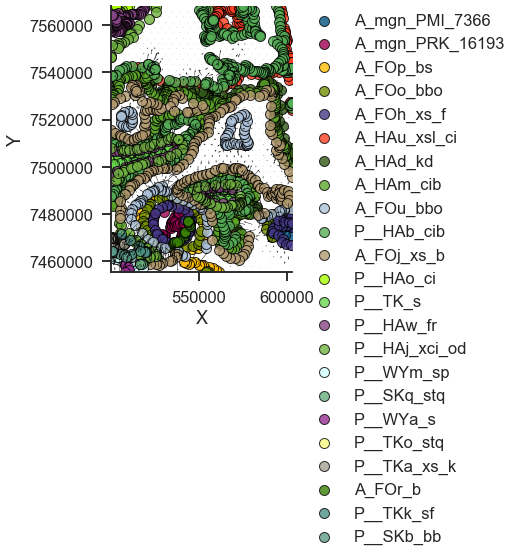

In [45]:
%matplotlib inline
gp.plot.plot_data(geo_model, direction='z');

## Load reprojected topgraphy to model

../test_data3/dtm/dtm_rp.tif
Cropped raster to geo_model.grid.extent.
[ 500057  603028 7455348 7567953] [191 174]
storing converted file...
Active grids: ['regular' 'topography']
A_mgn_PMI_7366
A_mgn_PRK_16193
Wyloo_Group
Shingle_Creek_Group
Turee_Creek_Group
Hamersley_Group
Fortescue_Group


,order_series,BottomRelation
A_mgn_PMI_7366,1,Erosion
A_mgn_PRK_16193,2,Erosion
Wyloo_Group,3,Erosion
Shingle_Creek_Group,4,Erosion
Turee_Creek_Group,5,Erosion
Hamersley_Group,6,Erosion
Fortescue_Group,7,Erosion


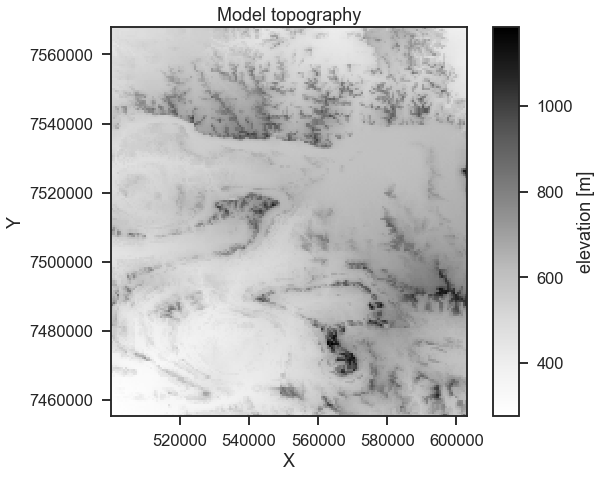

In [46]:
fp = dtm_reproj_file
print(fp)
geo_model.set_topography(source='gdal',filepath=fp)

## Load stratigraphic Series

f=open(tmp_path+'groups_clean.csv',"r")
contents =f.readlines()
f.close


faults = gp.Faults()
series = gp.Series(faults)
series.df

ngroups=contents[0].split(" ")
ngroups=int(ngroups[1])
groups=[]

for i in range (1,int(ngroups)+1):
    groups.append(contents[i].replace("\n",""))
    series.add_series(contents[i].replace("\n",""))
    print(contents[i].replace("\n",""))

series.delete_series('Default series')

series

## Load surfaces and assign to series

In [47]:
surfaces = gp.Surfaces(series)

#ngroups=5
for i in range(0,ngroups):
    f=open(tmp_path+groups[i]+'.csv',"r")
    contents =f.readlines()
    nformations=str(contents[0])
    nformations=nformations.split(" ")
    nformations=int(nformations[1].replace("\n",""))

    for j in range (1,int(nformations)+1):
        surfaces.add_surface(contents[j].replace("\n",""))
        d={groups[i]:contents[j].replace("\n","")}
        surfaces.map_series({groups[i]:(contents[j].replace("\n",""))}) #working but no gps
        #gp.map_series_to_surfaces(geo_model, {groups[0]:(contents[j].replace("\n",""))},#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX<<<<
              #  set_series=True, remove_unused_series=True)
    f.close

surfaces

,surface,series,order_surfaces,isBasement,color,id
0,A_mgn_PMI_7366,A_mgn_PMI_7366,1,False,#015482,1
1,A_mgn_PRK_16193,A_mgn_PRK_16193,1,False,#9f0052,2
2,P__WYm_sp,Wyloo_Group,1,False,#ffbe00,3
3,P__WYa_s,Wyloo_Group,2,False,#728f02,4
4,P__WYd_kd,Wyloo_Group,3,False,#443988,5
5,P__SKb_bb,Shingle_Creek_Group,1,False,#ff3f20,6
6,P__SKq_stq,Shingle_Creek_Group,2,False,#325916,7
7,P__TKa_xs_k,Turee_Creek_Group,1,False,#5DA629,8
8,P__TKo_stq,Turee_Creek_Group,2,False,#acc2d9,9
9,P__TKk_sf,Turee_Creek_Group,3,False,#56ae57,10


## Set Interpolation Data

In [48]:

id_only_one_bool = geo_model.surface_points.df['id'].value_counts() == 1
id_only_one = id_only_one_bool.index[id_only_one_bool]
single_vals = geo_model.surface_points.df[geo_model.surface_points.df['id'].isin(id_only_one)]
for idx, vals in single_vals.iterrows():
    geo_model.add_surface_points(vals['X'], vals['Y'], vals['Z'], vals['surface'])
    
geo_model.update_structure()


,values
isLith,True
isFault,False
number faults,0
number surfaces,23
number series,1
number surfaces per series,[23]
len surfaces surface_points,"[13, 79, 46, 48, 64, 214, 169, 264, 92, 372, 2..."
len series surface_points,[2096]
len series orientations,[1350]


In [49]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])

Compiling theano function...
Compilation Done!


## Provide summary data on model

In [50]:
geo_model.additional_data.structure_data

,values
isLith,True
isFault,False
number faults,0
number surfaces,23
number series,1
number surfaces per series,[23]
len surfaces surface_points,"[13, 79, 46, 48, 64, 214, 169, 264, 92, 372, 2..."
len series surface_points,[2096]
len series orientations,[1350]


## Calculate Model

In [51]:

gp.compute_model(geo_model)

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.38172e-17): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\gempy\core\solution.py:253: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e))



Lithology ids 
  [24. 24. 24. ...  1.  1.  1.] 

## Extract surfaces to visualize in 3D renderers

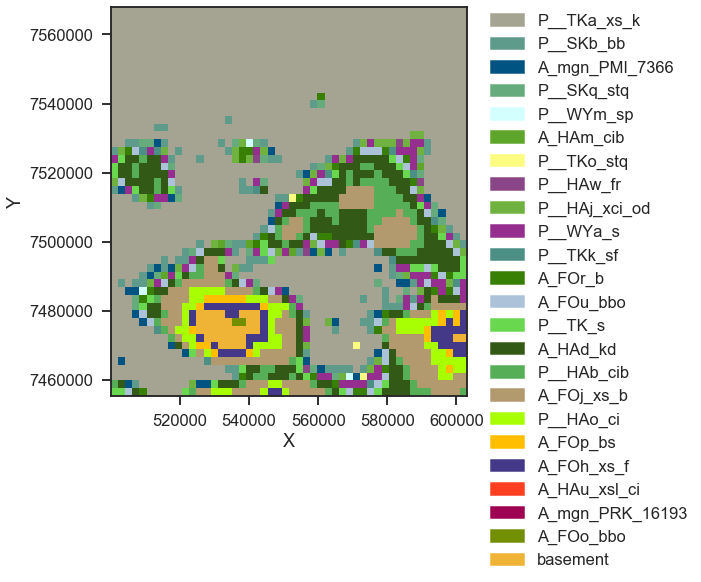

In [52]:
gp.plot.plot_section(geo_model, 49, direction='z', show_data=False)

In [53]:
ver , sim = gp.get_surfaces(geo_model)

import winsound
duration = 300  # milliseconds
freq = 500  # Hz
winsound.Beep(freq, duration)

## Visualise model

In [54]:
gp.plot.plot_3D(geo_model, render_data=False)

AttributeError: 'GemPyvtkInteract' object has no attribute 'topo_visualization'

closing vtk


In [55]:
from gempy import plot
#gp.plot.export_to_vtk(geo_model, path='./test_data3/vtk/', name='hams3.vtk', voxels=False, block=None, surfaces=True)